In [2]:
import pandas as pd
import spacy
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers, models

In [3]:
df = pd.read_json(open("../../data/data.json", "r", encoding="utf8"))

with open('../data/themes.json', 'r') as f:
    theme_codes = json.load(f)

In [10]:
themes_to_predict = ['arts & sciences', 'living', 'social commentaries', 
                     'relationships', 'love', 'nature', 'war', 'lgbtq', 'audio & music', 
                     'summer', 'religion', 'violence']

In [4]:
texts_len = df['text'].apply(len)
df.drop(df[texts_len<50].index, inplace=True)

In [5]:
max_features = 10000  # maximum number of words in vocabulari 5000
max_len = 150  # max length of string

In [7]:
joined_text = df['title'] + df['text']
X = keras.preprocessing.sequence.pad_sequences(list(joined_text), maxlen=max_len, padding='post')

### Model 

In [9]:
embedding_dim = 128
model1 = keras.models.Sequential([
  keras.layers.Embedding(input_dim=max_features,
                           output_dim=embedding_dim,
                           input_length=max_len),
  keras.layers.Flatten(),
  keras.layers.Dense(2000,activation='relu'),
  keras.layers.Dense(500,activation='relu'),
  keras.layers.Dense(100,activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 2000)              38402000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,732,701
Trainable params: 40,732,701
Non-trainable params: 0
____________________________________________

Theme #: arts & sciences
Epoch 1/5
367/367 [==============================] - 304s 828ms/step - loss: 0.1493 - binary_accuracy: 0.9677 - val_loss: 0.1625 - val_binary_accuracy: 0.9639
Epoch 2/5
367/367 [==============================] - 374s 1s/step - loss: 0.0396 - binary_accuracy: 0.9890 - val_loss: 0.5060 - val_binary_accuracy: 0.9601
Epoch 3/5
367/367 [==============================] - 399s 1s/step - loss: 0.0154 - binary_accuracy: 0.9982 - val_loss: 0.7610 - val_binary_accuracy: 0.9624
Epoch 4/5
367/367 [==============================] - 352s 960ms/step - loss: 0.0061 - binary_accuracy: 0.9991 - val_loss: 0.6739 - val_binary_accuracy: 0.9624
Epoch 5/5
41/41 [==============================] - 1s 29ms/step - loss: 0.6457 - binary_accuracy: 0.9609
Test Score Model1: 0.6456608176231384
Test Accuracy Model1: 0.9608595371246338


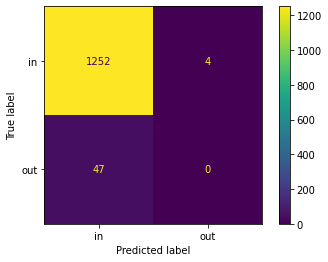

Theme #: living
Epoch 1/5
 22/367 [>.............................] - ETA: 2:27 - loss: 0.4029 - binary_accuracy: 0.9418

KeyboardInterrupt: 

In [12]:
epochs = 5
result = {}

for theme in themes_to_predict:
    print('Theme #:', theme)
    theme_index = theme_codes[theme]
    Y = np.array([row['themes'][theme_index] for index, row in df.iterrows()])
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.1, random_state=42)
   
    model1.fit(np.array(X_train), np.array(Y_train),
          #batch_size=128,
          validation_data=(np.array(X_test),np.array(Y_test)),
          epochs=epochs)
    score = model1.evaluate(np.array(X_test), np.array(Y_test)) 
    print("Test Score Model1:", score[0])
    print("Test Accuracy Model1:", score[1])
    y_pred = model1.predict(X_test)
    class_names = ['in ', 'out']
    cm = confusion_matrix(Y_test, np.rint(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
    result[theme] = score[1]
print(result)

In [ ]:
dfc = pd.DataFrame({'accuracies': result.values()}, index=result.keys())
ax = dfc.plot.bar(rot=45, figsize=(20, 10))